## Ekstraksi fitur gambar ke quantum

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # Gantilah tqdm.notebook dengan tqdm biasa
import cv2

In [25]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = r"hasil/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

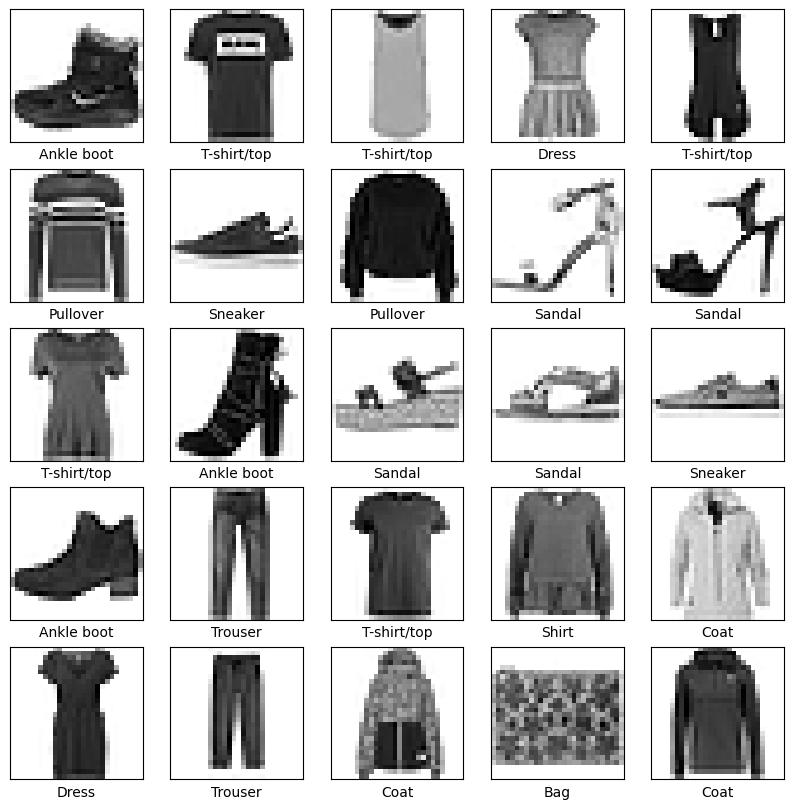

In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Load Fashion-MNIST dataset
fmnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist_dataset.load_data()

# Tentukan jumlah data yang ingin digunakan
n_train = 30000  # Ubah sesuai kebutuhan
n_test = 5000   # Ubah sesuai kebutuhan

# Kurangi ukuran dataset jika perlu
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalisasi nilai piksel ke dalam rentang [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Tambahkan dimensi ekstra untuk saluran konvolusi (grayscale)
train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

# 🔹 Tambahkan daftar nama kelas Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualisasi beberapa gambar dari dataset
plt.figure(figsize=(10, 10))
for i in range(25):  # Menampilkan 25 gambar pertama
    plt.subplot(5, 5, i + 1)
    plt.xticks([])  # Menghilangkan sumbu X
    plt.yticks([])  # Menghilangkan sumbu Y
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(), cmap=plt.cm.binary)  # Menghapus dimensi ekstra sebelum ditampilkan
    plt.xlabel(class_names[train_labels[i]])  # Menampilkan label kelas

plt.show()


In [47]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [48]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [57]:
from tqdm.notebook import tqdm  # Gunakan tqdm.notebook agar tampil di Colab

if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for img in tqdm(train_images, total=n_train, desc="Processing train images"):
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for img in tqdm(test_images, total=n_test, desc="Processing test images"):
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images_60.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images_10", q_test_images)

# Load pre-processed images
q_train_images = np.save(SAVE_PATH + "q_train_labels_30000.npy", train_labels)
q_test_images = np.save(SAVE_PATH + "q_test_labels.npy_5000", test_labels)


Quantum pre-processing of train images:


Processing train images:   0%|          | 0/30000 [00:00<?, ?it/s]


Quantum pre-processing of test images:


Processing test images:   0%|          | 0/5000 [00:00<?, ?it/s]

## klasifikasi menggunakan SVM dengan semua Kernel (data mentah)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Training SVM dengan kernel: linear...
Akurasi untuk kernel linear: 0.8250

Training SVM dengan kernel: poly...
Akurasi untuk kernel poly: 0.7700

Training SVM dengan kernel: rbf...
Akurasi untuk kernel rbf: 0.8050

Training SVM dengan kernel: sigmoid...
Akurasi untuk kernel sigmoid: 0.4750



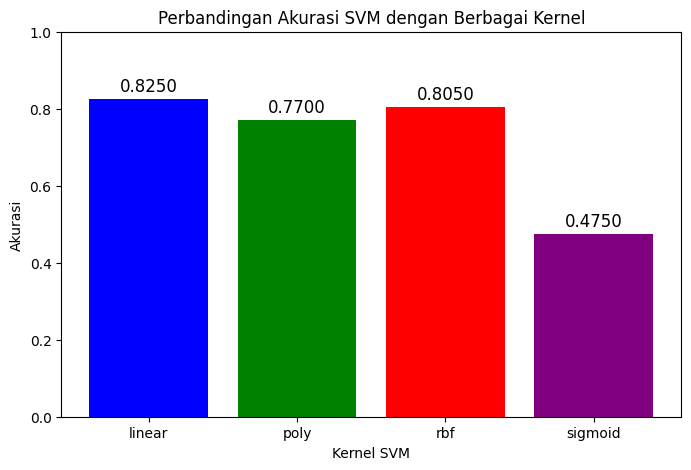

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow import keras

# Load Fashion-MNIST dataset
fmnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist_dataset.load_data()

# Gunakan subset data agar proses lebih cepat
n_train = 1000  # Bisa disesuaikan
n_test = 200   # Bisa disesuaikan
train_images, train_labels = train_images[:n_train], train_labels[:n_train]
test_images, test_labels = test_images[:n_test], test_labels[:n_test]

# Normalisasi nilai piksel ke dalam rentang [0,1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Ubah bentuk gambar dari (28,28) menjadi (784,) agar bisa digunakan oleh SVM
train_images = train_images.reshape(n_train, 28*28)
test_images = test_images.reshape(n_test, 28*28)

# Daftar kernel yang akan diuji
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = {}

# Loop untuk melatih SVM dengan berbagai kernel
for kernel in kernels:
    print(f"Training SVM dengan kernel: {kernel}...")
    svm_model = SVC(kernel=kernel, C=1.0, gamma='scale')  # Inisialisasi model SVM
    svm_model.fit(train_images, train_labels)  # Melatih model
    
    # Prediksi pada data uji
    predictions = svm_model.predict(test_images)
    
    # Hitung akurasi
    accuracy = accuracy_score(test_labels, predictions)
    accuracies[kernel] = accuracy
    print(f"Akurasi untuk kernel {kernel}: {accuracy:.4f}\n")

# Visualisasi hasil akurasi
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Kernel SVM")
plt.ylabel("Akurasi")
plt.title("Perbandingan Akurasi SVM dengan Berbagai Kernel")
plt.ylim(0, 1)  # Set batas akurasi dari 0 hingga 1
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)
plt.show()


## klasifikasi menggunakan CNN (data mentah)

c:\Users\user\Videos\belajar\Qml\CNN\Hugging Face\hug\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7831 - loss: 0.6099 - val_accuracy: 0.8730 - val_loss: 0.3529
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8857 - loss: 0.3123 - val_accuracy: 0.8865 - val_loss: 0.3156
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9038 - loss: 0.2605 - val_accuracy: 0.8900 - val_loss: 0.3030
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9179 - loss: 0.2231 - val_accuracy: 0.8895 - val_loss: 0.3045
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9284 - loss: 0.1936 - val_accuracy: 0.8938 - val_loss: 0.3008
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9384 - loss: 0.1664 - val_accuracy: 0.8988 - val_loss: 0.3086
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9443 - loss: 0.1460 - val_accuracy: 0.8973 - val_loss: 0.3189
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9525 - loss: 0.12

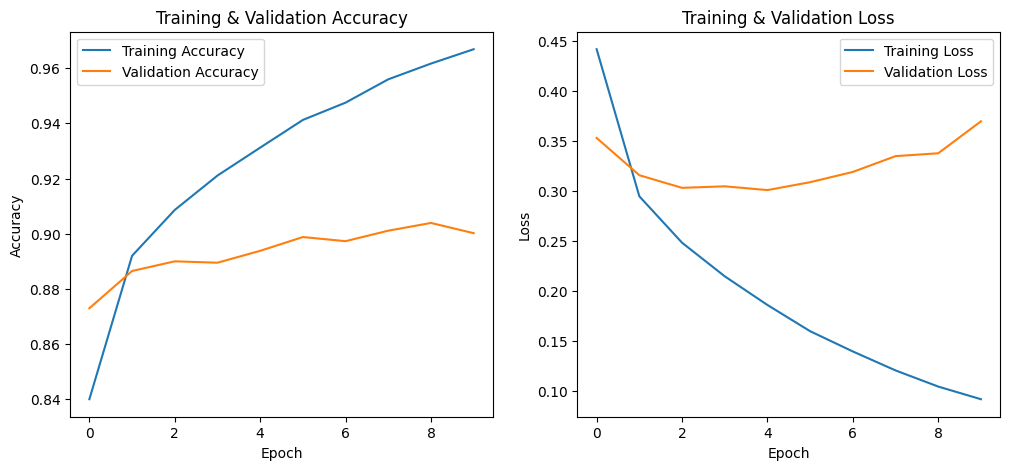

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Load Fashion-MNIST dataset
fmnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist_dataset.load_data()

# Normalisasi nilai piksel ke dalam rentang [0,1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Tambahkan dimensi ekstra untuk saluran konvolusi (grayscale)
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

# 🔹 Model CNN
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),  # Konvolusi 1
    keras.layers.MaxPooling2D(2,2),  # Pooling 1
    keras.layers.Conv2D(64, (3,3), activation='relu'),  # Konvolusi 2
    keras.layers.MaxPooling2D(2,2),  # Pooling 2
    keras.layers.Flatten(),  # Flatten layer
    keras.layers.Dense(128, activation='relu'),  # Fully Connected layer
    keras.layers.Dense(10, activation='softmax')  # Output layer (10 kelas)
])

# Kompilasi model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 🔹 Latih model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# 🔹 Evaluasi model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'\nAkurasi pada data uji: {test_acc:.4f}')

# 🔹 Visualisasi Akurasi dan Loss
plt.figure(figsize=(12,5))

# Plot akurasi
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


## D


In [43]:
from sklearn.decomposition import PCA


In [54]:
X_train = np.load(r"hasil\q_train_images_60.npy")
y_train = np.load(r"hasil\q_train_labels_60.npy")
X_test = np.load(r"hasil\q_test_images_10.npy")
y_test = np.load(r"hasil\q_test_labels_10.npy")

In [45]:
print(X_train.shape)


(60, 4)


In [44]:
# Ubah data menjadi 2D jika masih dalam bentuk 3D atau 4D
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Pastikan tidak ada NaN
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Sesuaikan jumlah komponen PCA dengan jumlah fitur yang tersedia
n_components = min(4, X_train.shape[1])  

# Lakukan PCA
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Define a quantum device
n_qubits = n_components  # Use reduced number of qubits
dev = qml.device("default.qubit", wires=n_qubits)

# Define a quantum embedding
@qml.qnode(dev)
def quantum_embedding(x):
    qml.AngleEmbedding(x, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights=np.ones((1, n_qubits)), wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

# Compute the quantum kernel with progress tracking
def quantum_kernel(X1, X2):
    kernel_matrix = np.zeros((len(X1), len(X2)))
    for i in tqdm(range(len(X1)), desc="Computing Quantum Kernel"):
        for j in range(len(X2)):
            kernel_matrix[i, j] = np.dot(quantum_embedding(X1[i]), quantum_embedding(X2[j]))
    return kernel_matrix

# Compute the kernel matrix
kernel_matrix = quantum_kernel(X_train, X_train)

# Train the classical SVM with the quantum kernel
clf = SVC(kernel="precomputed")
clf.fit(kernel_matrix, y_train)

# Prediction function with progress tracking
def predict(X_test):
    kernel_test = np.zeros((len(X_test), len(X_train)))
    for i in tqdm(range(len(X_test)), desc="Computing Test Kernel"):
        for j in range(len(X_train)):
            kernel_test[i, j] = np.dot(quantum_embedding(X_test[i]), quantum_embedding(X_train[j]))
    return clf.predict(kernel_test)

# Test the classifier
predictions = predict(X_test)
accuracy = np.mean(predictions == y_test)
print("Accuracy:", accuracy)


Computing Quantum Kernel:   0%|          | 0/60 [00:00<?, ?it/s]

Computing Test Kernel:   0%|          | 0/19 [00:00<?, ?it/s]

Accuracy: 0.05263157894736842
